In [1]:
import pandas as pd 
import numpy as np
import lightgbm as lgbm
import sklearn as sk
import xgboost as xgb
from sklearn import model_selection
from sklearn import ensemble
from sklearn import preprocessing as sk_prep
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
#load data from our local data folder
base_path = "./data/"
file = "churn_demo.csv"

#drop features that will not be useful, they are either identifiers of the customer or 
#personal information without any relation with their churn likelihood
df_base = pd.read_csv(base_path+file).drop(columns=['RowNumber', 'Surname', 'CustomerId'], axis = 1)

df_base.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
#how much data do we have?
print(df_base.shape)


(10000, 11)


In [4]:
#create metadata 
label = 'Exited'
df_columns = list(df_base.columns)
df_columns.remove(label)
print(df_columns)


['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [5]:
#encoders 
l_binarizer = sk_prep.LabelBinarizer()
str_encoder = sk_prep.OrdinalEncoder()

#binarize label
y_encoded = l_binarizer.fit_transform(y=df_base[label])

#encode strings
X_encoded = pd.DataFrame(str_encoder.fit_transform(X=df_base.drop(columns = [label], axis = 1)),
                            columns = df_columns)

X_encoded.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0
5,254.0,2.0,1.0,26.0,8.0,2674.0,1.0,1.0,0.0,7531.0
6,431.0,0.0,1.0,32.0,7.0,0.0,1.0,1.0,1.0,513.0
7,8.0,1.0,0.0,11.0,4.0,2781.0,3.0,1.0,0.0,5978.0
8,110.0,0.0,1.0,26.0,4.0,4962.0,1.0,0.0,1.0,3718.0
9,293.0,0.0,1.0,9.0,2.0,4450.0,0.0,1.0,1.0,3550.0


In [6]:
#split data in 70-30 ratios
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, y_encoded, test_size = 0.3)

print(X_train.shape, X_test.shape)


(7000, 10) (3000, 10)


In [7]:
#fit a random forest with 100 trees of maximum 8 levels
rf = ensemble.RandomForestClassifier(n_estimators = 100, 
        max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [8]:
#function to plot the ROC curve
def get_roc_curve(X_train, y_train, X_test, y_test, model): 
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--', color = "red")
    # plot the precision-recall curve for the model
    plt.plot(fpr, tpr, marker='.', color = "blue")
    # show the plot
    plt.show()


In [9]:
from sklearn import metrics

#predict using our test set and print different error measures
preds_proba_rf = rf.predict_proba(X=X_test)
preds_rf = rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Confusion matrix: \n", confusion_matrix(y_test, preds_rf))


Accuracy:  0.86
Precision:  0.39
Recall:  0.82
F1:  0.53
Confusion matrix: 
 [[2323   55]
 [ 378  244]]


AUC: 0.849


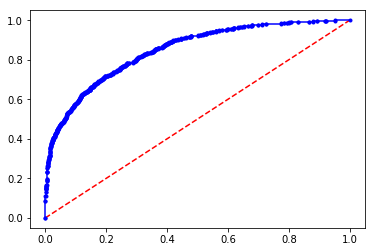

In [10]:
#get the roc curve to check if we are better than a random classifier
get_roc_curve(X_train, y_train,X_test, y_test, rf)
